In [1]:
import numpy as np
%matplotlib notebook
%matplotlib notebook
#%matplotlib inline
import matplotlib.pyplot as plt
np.random.seed(18)
import tqdm
import matplotlib.animation as animation

Relu neurons

In [2]:
d = 2 # dimension of space
M = 5 # number of neurons for generation

In [3]:
def relu(x):
    if x >= 0:
        return x
    return 0.

In [4]:
def drelu(x):
    if x >= 0:
        return 1.
    return 0.

In [5]:
class Neuron:
    def __init__(self):
        a = np.random.normal()
        w = np.random.normal(size = d)
        b = np.random.normal()
        norm = np.linalg.norm(np.concatenate([np.array([b]), w]), 2)
        #norm = np.linalg.norm(np.concatenate([np.array([a, b]), w]), 2)
        #self.a = a / norm
        self.a = a
        self.w = w / norm
        self.b = b / norm
    def set_weights(self, a, w, b):
        self.a = a
        self.w = w.copy()
        self.b = b
    def forward(self, x):
        return self.a * relu(self.w.dot(x) + self.b)

In [6]:
x, y = np.zeros(10), np.zeros(10)
np.array([x, y]).shape

(2, 10)

In [7]:
class Network:
    def __init__(self, width):
        self.width = width
        self.neurons = [Neuron() for i in range(width)]
    def small_sphere(self, R):
        for nr in self.neurons:
            norm = 1./R * np.linalg.norm(np.concatenate([np.array([nr.b]), nr.w]), 2)
            nr.set_weights(nr.a, nr.w/norm, nr.b/norm)
        return
    def output(self, x):
        return np.mean([n.forward(x) for n in self.neurons])
    def loss(self, x, y):
        return .5*(self.output(x) - y)**2
    def grad(self, x, y):
        d = (self.output(x) - y)
        s = np.array([relu(n.w.dot(x) + n.b) for n in self.neurons])
        ds = np.array([drelu(n.w.dot(x) + n.b) for n in self.neurons])
        ga = 1./self.width * d * s
        gb = 1./self.width * d * np.array([self.neurons[i].a*ds[i] for i in range(self.width)])
        gw = np.array([gb[i] * x for i in range(self.width)]) # shape m * d
        return ga, gw, gb
    def step(self, x, y, tau):
        ga, gw, gb = self.grad(x, y)
        for i in range(self.width):
            nr = self.neurons[i]
            a_new = nr.a - tau * ga[i]
            w_new = nr.w - tau * gw[i]
            b_new = nr.b - tau * gb[i]
            nr.set_weights(a_new, w_new, b_new)
    def batch_step(self, X, Y, tau):
        ba = X.shape[0]
        Ga, Gw, Gb = np.zeros((ba, self.width)), np.zeros((ba, self.width, d)), np.zeros((ba, self.width))
        for i in range(ba):
            Ga[i], Gw[i], Gb[i] = self.grad(X[i], Y[i])
        ga, gw, gb = Ga.mean(axis = 0), Gw.mean(axis = 0), Gb.mean(axis = 0)
        for i in range(self.width):
            nr = self.neurons[i]
            a_new = nr.a - tau * ga[i]
            w_new = nr.w - tau * gw[i]
            b_new = nr.b - tau * gb[i]
            nr.set_weights(a_new, w_new, b_new)
    def sgd_train(self, X, Y, tau, epochs, batch, disp = True):
        for e in range(epochs):
            pm = np.random.permutation(X.shape[0])
            X = np.array([X[pm[i]] for i in range(X.shape[0])])
            Y = np.array([Y[pm[i]] for i in range(Y.shape[0])])
            if batch > 1:
                nbatch = X.shape[0]//batch
                subX = np.split(X, nbatch)
                subY = np.split(Y, nbatch)
                for s in range(len(subX)):
                    self.batch_step(subX[s], subY[s], tau)
            else:
                for i in range(X.shape[0]):
                    self.step(X[i], Y[i], tau)
            loss = self.test(X, Y)
            if disp:
                print('epoch '+str(e)+' : '+str(loss))
        return loss
    def test(self, X_t, Y_t):
        ts = X_t.shape[0]
        return np.mean([self.loss(X_t[i], Y_t[i]) for i in range(ts)])
    def gen_sample(self, s = 1):
        if s==1:
            X = np.random.normal(size = d)
            Y = self.output(X)
            return X, Y
        else:
            X = np.random.normal(size = (s, d))
            Y = np.zeros(s)
            for i in range(s):
                Y[i] = self.output(X[i])
            return X, Y
    def give_weights(self):
        la, lw, lb = np.zeros(self.width), np.zeros((self.width, d)), np.zeros(self.width)
        for i in range(self.width):
            nr = self.neurons[i]
            la[i] = nr.a
            lw[i] = nr.w
            lb[i] = nr.b
        return la, lw, lb
    def display_weights(self, fig, ax, scat = None, true_w = None, color='b'):
        assert d==2, 'must be in dimension 2'
        #ax.cla()
        ax.set_xlim((-2, 2))
        ax.set_ylim((-2, 2))
        la, lw, _ = self.give_weights()
        x, y = np.zeros(self.width), np.zeros(self.width)
        for k in range(self.width):
            x[k] = lw[k, 0] * la[k]
            y[k] = lw[k, 1] * la[k] 
        if scat is None:
            pos = ax.scatter(x, y, s = 10., color=color)
        else:
            scat.set_offsets(np.array([x, y]).T)
            trace = ax.scatter(x, y, s = 5., color='grey')
        if true_w is not None:
            tla, tlw, tlb = true_w
            tx, ty = np.zeros(tla.shape[0]), np.zeros(tla.shape[0])
            for k in range(tla.shape[0]):
                tx[k] = tlw[k, 0] * tla[k]
                ty[k] = tlw[k, 1] * tla[k]
                if tx[k]>= 0:
                    u = np.linspace(0., 2., 10)
                else:
                    u = np.linspace(-2., 0., 10)
                v = ty[k]/tx[k] * u
                ax.plot(u, v, color = 'k')
            ax.scatter(tx, ty, s = 10., color='r')
                
        if scat is None:
            fig.canvas.draw()
        

<IPython.core.display.Javascript object>


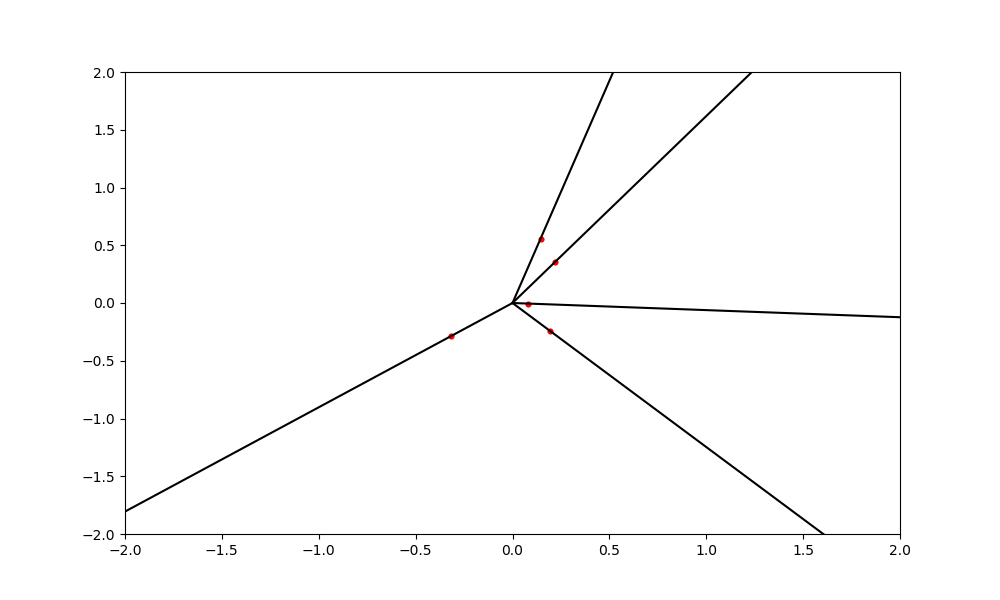

In [8]:
#fig, ax = plt.subplots(figsize=(5, 3))
fig, ax = plt.subplots(figsize=(10, 6))


gen_net = Network(M)
true_w = gen_net.give_weights()
gen_net.display_weights(fig, ax, color='r', true_w = true_w)

Initialize new network with parameters normal on small sphere.

Train it using SGD

Trying to reproduce the visual experiment

In [9]:
net = Network(20)
net.small_sphere(0.05)

<IPython.core.display.Javascript object>


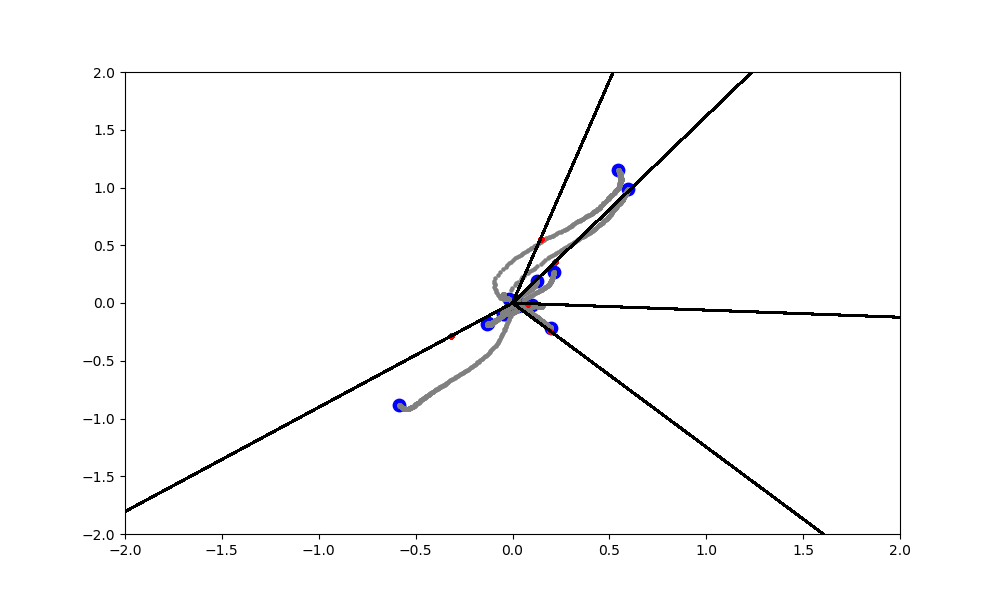

In [10]:
fig, ax = plt.subplots(figsize=(10, 6))

numframes = 500

scat = ax.scatter(None, None, s = 80., color='b')

def update_plot(i, scat, ax):
    #scat.set_array(data[i])
    print(int(50*np.log(10.+i)))
    X, Y = gen_net.gen_sample(50*int(np.log(10.+i)))
    net.sgd_train(X, Y, tau = .1, batch = 10, epochs = 1, disp = False)
    
    net.display_weights(fig, ax, scat, true_w = true_w)
    return scat,

ani = animation.FuncAnimation(fig, update_plot, frames=numframes,
                                  fargs=(scat, ax), interval = 5, blit=True)


#plt.show()
#fig.canvas.draw()

In [11]:
ani.save('./new_ani.gif', writer='imagemagick', fps=60, bitrate = 0.05)

115
115
119
124
128
131
135
138
141
144
147
149
152
154
156
158
160
162
164
166
168
170
171
173
174
176
177
179
180
181
183
184
185
186
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
203
204
205
206
207
207
208
209
210
210
211
212
213
213
214
215
215
216
217
217
218
219
219
220
220
221
222
222
223
223
224
224
225
226
226
227
227
228
228
229
229
230
230
231
231
232
232
233
233
234
234
235
235
235
236
236
237
237
238
238
238
239
239
240
240
241
241
241
242
242
242
243
243
244
244
244
245
245
245
246
246
247
247
247
248
248
248
249
249
249
250
250
250
251
251
251
252
252
252
253
253
253
254
254
254
254
255
255
255
256
256
256
257
257
257
257
258
258
258
259
259
259
259
260
260
260
261
261
261
261
262
262
262
262
263
263
263
263
264
264
264
264
265
265
265
265
266
266
266
266
267
267
267
267
268
268
268
268
268
269
269
269
269
270
270
270
270
271
271
271
271
271
272
272
272
272
272
273
273
273
273
274
274
274
274
274
275
275
275
275
275
276
276
276
276
276
277
277
277
277


In [11]:
#help(ani.save)

In [12]:
#!brew install imagemagick 

119


In [13]:
#fig, ax = plt.subplots(figsize=(5, 3))
#net.display_weights(fig, ax, true_w = true_w)

#for i in range(1000):
#    X, Y = gen_net.gen_sample(100)
#    net.sgd_train(X, Y, tau = .5, batch = 10, epochs = 1, disp = False)
#    net.display_weights(fig, ax, true_w = true_w)

ReLU activation function: we show for each particle the trajectory $|w(t)| \theta(t) \in R^2$
 (here = a * w). The initialization is uniformly random on a (small) sphere around 0 (this satisfies asymptotically the separation condition). This case has a homogeneous structure and is treated separately in the paper.

What is the influence of:
    - the size of the initial weights sphere ?
    - the number of units ?
    - the original problem configuration ?